#Tutorial 5 - DQN

Please follow this tutorial to understand the structure (code) of DQN algorithm.


### References:

Please follow [Human-level control through deep reinforcement learning](https://www.nature.com/articles/nature14236) for the original publication as well as the psuedocode. Watch Prof. Ravi's lectures on moodle or nptel for further understanding of the core concepts. Contact the TAs for further resources if needed.


In [1]:
'''
Installing packages for rendering the game on Colab
'''

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1
!pip install gym[classic_control]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 39.0 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2


In [2]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from PIL import Image

In [4]:
'''
Please refer to the first tutorial for more details on the specifics of environments
We've only added important commands you might find useful for experiments.
'''

'''
List of example environments
(Source - https://gym.openai.com/envs/#classic_control)

'Acrobot-v1'
'Cartpole-v1'
'MountainCar-v0'
'''

env = gym.make('Acrobot-v1')
env.seed(0)

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n

print(state_shape)
print(no_of_actions)
print(env.action_space.sample())
print("----")

'''
# Understanding State, Action, Reward Dynamics

The agent decides an action to take depending on the state.

The Environment keeps a variable specifically for the current state.
- Everytime an action is passed to the environment, it calculates the new state and updates the current state variable.
- It returns the new current state and reward for the agent to take the next action

'''

state = env.reset()
''' This returns the initial state (when environment is reset) '''

print(state)
print("----")

action = env.action_space.sample()
''' We take a random action now '''

print(action)
print("----")

next_state, reward, done, info = env.step(action)
''' env.step is used to calculate new state and obtain reward based on old state and action taken  '''

print(next_state)
print(reward)
print(done)
print(info)
print("----")


6
3
0
----
[ 0.99962485  0.02738891  0.9989402  -0.04602639 -0.09180529 -0.09669447]
----
2
----
[ 0.99996984 -0.0077642   0.9997182  -0.02373883 -0.25169677  0.31000718]
-1.0
False
{}
----


## DQN

Using NNs as substitutes isn't something new. It has been tried earlier, but the 'human control' paper really popularised using NNs by providing a few stability ideas (Q-Targets, Experience Replay & Truncation). The 'Deep-Q Network' (DQN) Algorithm can be broken down into having the following components.

### Q-Network:
The neural network used as a function approximator is defined below

In [5]:

import torch
import torch.nn as nn
import torch.nn.functional as F



class QNetwork1(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=64, fc_value_units=256, fc_adv_units=256):
        super(QNetwork1, self).__init__()

        self.fc1 = nn.Linear(6, 64)
        self.relu = nn.ReLU()
        self.fc_value = nn.Linear(64, 256)
        self.fc_adv = nn.Linear(64, 256)

        self.value = nn.Linear(256, 1)
        self.adv = nn.Linear(256, action_size)

    def forward(self, state):
        y = self.relu(self.fc1(state))
        value = self.relu(self.fc_value(y))
        adv = self.relu(self.fc_adv(y))

        value = self.value(value)
        adv = self.adv(adv)

        max_adv = torch.max(adv, dim=1, keepdim=True)[0]
        Q = value + adv - max_adv

        return Q




In [6]:
class QNetwork2(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=64, fc_value_units=256, fc_adv_units=256):
        super(QNetwork2, self).__init__()

        self.fc1 = nn.Linear(6, 64)
        self.relu = nn.ReLU()
        self.fc_value = nn.Linear(64, 256)
        self.fc_adv = nn.Linear(64, 256)

        self.value = nn.Linear(256, 1)
        self.adv = nn.Linear(256, action_size)

    def forward(self, state):
        y = self.relu(self.fc1(state))
        value = self.relu(self.fc_value(y))
        adv = self.relu(self.fc_adv(y))

        value = self.value(value)
        adv = self.adv(adv)

        advAverage = torch.mean(adv, dim=1, keepdim=True)
        Q = value + adv - advAverage


        return Q




### Replay Buffer:

Recall why we use such a technique.

In [7]:
import random
import torch
import numpy as np
from collections import deque, namedtuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Tutorial Agent Code:


In [8]:
class TutorialAgent():

    def __init__(self, state_size, action_size, seed, config):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.config = config

        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork1(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=config.LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, config.BUFFER_SIZE, config.BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= self.config.BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, self.config.GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''
        self.t_step = (self.t_step + 1) % self.config.UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=0.):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
      """Perform a training iteration on a batch of data."""
      states, actions, rewards, next_states, dones = experiences

      # Get max predicted Q values (for next states) from target model
      Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

      # Compute Q targets for current states
      Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

      # Get expected Q values from local model
      Q_expected = self.qnetwork_local(states).gather(1, actions)

      # Compute loss
      loss = F.mse_loss(Q_expected, Q_targets)

      # Minimize the loss
      self.optimizer.zero_grad()
      loss.backward()

      # Gradient Clipping
      for param in self.qnetwork_local.parameters():
          param.grad.data.clamp_(-1, 1)

      self.optimizer.step()

      return loss.item()  # Convert loss to a scalar value for logging purposes


### Here, we present the DQN algorithm code.

In [9]:
''' Defining DQN Algorithm '''

state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n


def dqn(agent,n_episodes=600, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):

    scores_window = deque(maxlen=100)
    ''' last 100 scores for checking if the avg is more than 195 '''

    eps = eps_start
    regret = 0
    ''' initialize epsilon '''

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break

        regret += -score
        scores_window.append(score)

        eps = max(eps_end, eps_decay*eps)
        ''' decrease epsilon '''

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

        if i_episode % 100 == 0:
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

    return regret

# Define a function to run the DQN algorithm multiple times and return the average regret over 5 runs
def average_return_over_5_runs(agent):
    total_regret = 0
    for _ in range(1):
        regret = dqn(agent=agent)
        total_regret += regret
    return total_regret / 5




In [ ]:
!wandb login 121b0a1a592662d289422b9d2bbeb4b36bc0c6e2

wandb: Appending key for api.wandb.ai to your netrc file: /home/leon/.netrc


In [ ]:
import wandb

def main():
    wandb.init(project="DQN_max_acrobat_final")
    agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0, config=wandb.config)
    score = dqn(agent=agent)
    wandb.log({"score": score})

# 2: Define the search space
sweep_configuration = {
    "method": "bayes",
    "metric": {"goal": "minimize", "name": "score"},
    "parameters": {
        "BUFFER_SIZE": {"values": [1e5,1e6,1e4]},
        "BATCH_SIZE": {"max": 256, "min": 32},
        "GAMMA": {"values": [0.99]},
        "LR": {"max": 1e-3, "min": 1e-5},
        "UPDATE_EVERY": {"max": 100, "min": 10},
    },
}

# 3: Start the sweep
sweep_id = wandb.sweep(sweep=sweep_configuration, project="DQN_max_acrobat_final")

wandb.agent(sweep_id, function=main, count=10)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: 8meafk3y
Sweep URL: https://wandb.ai/iitm-ac-in/DQN_max_acrobat_final/sweeps/8meafk3y


wandb: Agent Starting Run: sbday95y with config:
wandb: 	BATCH_SIZE: 207
wandb: 	BUFFER_SIZE: 10000
wandb: 	GAMMA: 0.99
wandb: 	LR: 0.0004478892273220252
wandb: 	UPDATE_EVERY: 79
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ed21b038 (iitm-ac-in). Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
/home/leon/miniconda3/envs/RL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


Episode 100	Average Score: -354.02
Episode 200	Average Score: -231.42
Episode 300	Average Score: -130.89
Episode 400	Average Score: -109.44
Episode 500	Average Score: -103.66
Episode 600	Average Score: -91.025


/home/leon/miniconda3/envs/RL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


score,▁
score,102045.0


wandb: Agent Starting Run: jm1u9b97 with config:
wandb: 	BATCH_SIZE: 128
wandb: 	BUFFER_SIZE: 10000
wandb: 	GAMMA: 0.99
wandb: 	LR: 0.0001814819662204888
wandb: 	UPDATE_EVERY: 100
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
/home/leon/miniconda3/envs/RL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


Episode 100	Average Score: -328.56
Episode 200	Average Score: -142.93
Episode 300	Average Score: -119.51
Episode 400	Average Score: -99.641
Episode 500	Average Score: -96.183
Episode 600	Average Score: -93.47


score,▁
score,88029.0


wandb: Agent Starting Run: zitsdez3 with config:
wandb: 	BATCH_SIZE: 180
wandb: 	BUFFER_SIZE: 10000
wandb: 	GAMMA: 0.99
wandb: 	LR: 0.0007880856074323002
wandb: 	UPDATE_EVERY: 37
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
/home/leon/miniconda3/envs/RL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


Episode 100	Average Score: -445.72
Episode 200	Average Score: -330.89
Episode 300	Average Score: -169.88
Episode 400	Average Score: -126.83
Episode 500	Average Score: -113.22
Episode 600	Average Score: -100.40


score,▁
score,128694.0


wandb: Agent Starting Run: rvp5zii1 with config:
wandb: 	BATCH_SIZE: 132
wandb: 	BUFFER_SIZE: 10000
wandb: 	GAMMA: 0.99
wandb: 	LR: 0.00024152865780333388
wandb: 	UPDATE_EVERY: 100
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
/home/leon/miniconda3/envs/RL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


Episode 100	Average Score: -317.36
Episode 200	Average Score: -152.60
Episode 300	Average Score: -114.39
Episode 400	Average Score: -97.941
Episode 500	Average Score: -92.56
Episode 600	Average Score: -90.90


score,▁
score,86575.0


wandb: Agent Starting Run: 4bt3qo7w with config:
wandb: 	BATCH_SIZE: 69
wandb: 	BUFFER_SIZE: 10000
wandb: 	GAMMA: 0.99
wandb: 	LR: 0.00019885816182225495
wandb: 	UPDATE_EVERY: 95
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
/home/leon/miniconda3/envs/RL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


Episode 100	Average Score: -328.67
Episode 200	Average Score: -152.46
Episode 300	Average Score: -117.48
Episode 400	Average Score: -102.57
Episode 500	Average Score: -94.545
Episode 600	Average Score: -92.25


score,▁
score,88797.0


wandb: Agent Starting Run: ey3txsn9 with config:
wandb: 	BATCH_SIZE: 82
wandb: 	BUFFER_SIZE: 10000
wandb: 	GAMMA: 0.99
wandb: 	LR: 0.0002696903401162998
wandb: 	UPDATE_EVERY: 99
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
/home/leon/miniconda3/envs/RL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


Episode 100	Average Score: -339.86
Episode 200	Average Score: -162.07
Episode 300	Average Score: -113.39
Episode 400	Average Score: -104.79
Episode 500	Average Score: -92.380
Episode 600	Average Score: -89.51


score,▁
score,90200.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kew73ybv with config:
wandb: 	BATCH_SIZE: 52
wandb: 	BUFFER_SIZE: 1000000
wandb: 	GAMMA: 0.99
wandb: 	LR: 1.2826908049107016e-05
wandb: 	UPDATE_EVERY: 99
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
/home/leon/miniconda3/envs/RL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


Episode 100	Average Score: -368.66
Episode 200	Average Score: -242.87
Episode 300	Average Score: -142.98
Episode 400	Average Score: -106.83
Episode 500	Average Score: -99.606
Episode 600	Average Score: -98.289


score,▁
score,105922.0


wandb: Agent Starting Run: k9jgagt3 with config:
wandb: 	BATCH_SIZE: 140
wandb: 	BUFFER_SIZE: 10000
wandb: 	GAMMA: 0.99
wandb: 	LR: 0.00012432737628539022
wandb: 	UPDATE_EVERY: 91
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
/home/leon/miniconda3/envs/RL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


Episode 100	Average Score: -332.97
Episode 200	Average Score: -151.64
Episode 300	Average Score: -109.37
Episode 400	Average Score: -98.369
Episode 500	Average Score: -88.78
Episode 600	Average Score: -91.36


score,▁
score,87248.0


wandb: Agent Starting Run: t6bfoqkr with config:
wandb: 	BATCH_SIZE: 54
wandb: 	BUFFER_SIZE: 10000
wandb: 	GAMMA: 0.99
wandb: 	LR: 0.00022889801536429415
wandb: 	UPDATE_EVERY: 96
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
/home/leon/miniconda3/envs/RL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


Episode 100	Average Score: -334.73
Episode 200	Average Score: -145.24
Episode 300	Average Score: -111.97
Episode 400	Average Score: -101.51
Episode 500	Average Score: -96.355
Episode 600	Average Score: -90.71


score,▁
score,88051.0


wandb: Agent Starting Run: 451jisey with config:
wandb: 	BATCH_SIZE: 139
wandb: 	BUFFER_SIZE: 10000
wandb: 	GAMMA: 0.99
wandb: 	LR: 1.9544989595346695e-05
wandb: 	UPDATE_EVERY: 97
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
/home/leon/miniconda3/envs/RL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


Episode 100	Average Score: -375.06
Episode 200	Average Score: -159.99
Episode 300	Average Score: -113.91
Episode 400	Average Score: -106.76
Episode 500	Average Score: -93.638
Episode 600	Average Score: -87.99


score,▁
score,93734.0


In [19]:
LR = 0.00005615
BUFFER_SIZE = 1000000
BATCH_SIZE = 221
GAMMA = 0.99
UPDATE_EVERY = 43

class TutorialAgentrun():

    def __init__(self, state_size, action_size, seed):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork1(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=0.):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
      """Perform a training iteration on a batch of data."""
      states, actions, rewards, next_states, dones = experiences

      # Get max predicted Q values (for next states) from target model
      Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

      # Compute Q targets for current states
      Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

      # Get expected Q values from local model
      Q_expected = self.qnetwork_local(states).gather(1, actions)

      # Compute loss
      loss = F.mse_loss(Q_expected, Q_targets)

      # Minimize the loss
      self.optimizer.zero_grad()
      loss.backward()

      # Gradient Clipping
      for param in self.qnetwork_local.parameters():
          param.grad.data.clamp_(-1, 1)

      self.optimizer.step()

      return loss.item()  # Convert loss to a scalar value for logging purposes


In [17]:
state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n

def dqn_run(seed_list,n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    all_returns = []  # List to store returns for each episode across all runs

    for i in range(5):  # Run the DQN algorithm five times
        agent = TutorialAgentrun(state_size=state_shape,action_size = action_shape,seed = seed_list[i])
        scores_window = deque(maxlen=100)
        eps = eps_start
        returns = []  # List to store returns for each episode in this run
        for i_episode in range(1, n_episodes+1):
            state = env.reset()
            score = 0
            if i_episode % 100 == 0:
              print(i_episode)
            for t in range(max_t):
                action = agent.act(state, eps)
                next_state, reward, done, _ = env.step(action)
                agent.step(state, action, reward, next_state, done)
                state = next_state
                score += reward
                if done:
                    break

            scores_window.append(score)
            eps = max(eps_end, eps_decay*eps)

            returns.append(score)  # Store the return for this episode

        all_returns.append(returns)  # Store the returns for this run

    return all_returns



In [ ]:
seed_lst = [2,45,33,11,9]
DQN_avg_list = dqn_run(seed_lst)

In [20]:
LR = 0.0002415
BUFFER_SIZE = 10000
BATCH_SIZE = 132
GAMMA = 0.99
UPDATE_EVERY = 100

class TutorialAgentrunmax():

    def __init__(self, state_size, action_size, seed):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        ''' Q-Network '''
        self.qnetwork_local = QNetwork2(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork2(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=0.):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
      """Perform a training iteration on a batch of data."""
      states, actions, rewards, next_states, dones = experiences

      # Get max predicted Q values (for next states) from target model
      Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

      # Compute Q targets for current states
      Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

      # Get expected Q values from local model
      Q_expected = self.qnetwork_local(states).gather(1, actions)

      # Compute loss
      loss = F.mse_loss(Q_expected, Q_targets)

      # Minimize the loss
      self.optimizer.zero_grad()
      loss.backward()

      # Gradient Clipping
      for param in self.qnetwork_local.parameters():
          param.grad.data.clamp_(-1, 1)

      self.optimizer.step()

      return loss.item()  # Convert loss to a scalar value for logging purposes


In [23]:
def dqn_runmax(seed_list,n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    all_returns = []  # List to store returns for each episode across all runs

    for i in range(5):  # Run the DQN algorithm five times
        agent = TutorialAgentrunmax(state_size=state_shape,action_size = action_shape,seed = seed_list[i])
        scores_window = deque(maxlen=100)
        eps = eps_start
        returns = []  # List to store returns for each episode in this run
        for i_episode in range(1, n_episodes+1):
            state = env.reset()
            score = 0
            for t in range(max_t):
                action = agent.act(state, eps)
                next_state, reward, done, _ = env.step(action)
                agent.step(state, action, reward, next_state, done)
                state = next_state
                score += reward
                if done:
                    break

            scores_window.append(score)
            eps = max(eps_end, eps_decay*eps)
            if i_episode % 100 == 0:
              print(i_episode)

            returns.append(score)  # Store the return for this episode

        all_returns.append(returns)  # Store the returns for this run

    return all_returns

# Example usage:
# Replace 'agent' and 'env' with your agent and environment objects
# Also, adjust other parameters as needed

# all_returns = dqn_run(agent, env)


In [ ]:
seed_lst = [2,45,33,11,9]
DQN_max_list = dqn_runmax(seed_lst)

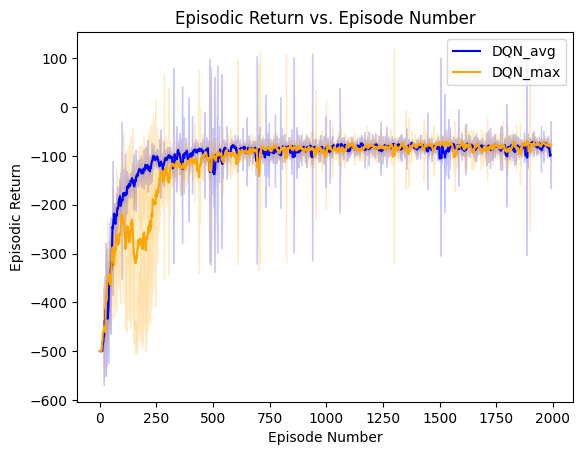

In [27]:
import numpy as np
import matplotlib.pyplot as plt

mean_returns_1 = np.mean(DQN_avg_list, axis=0)
variance_returns_1 = np.var(DQN_avg_list, axis=0)

mean_returns_2 = np.mean(DQN_max_list, axis=0)
variance_returns_2 = np.var(DQN_max_list, axis=0)

smooth_mean_returns_1 = np.convolve(mean_returns_1, np.ones((10,))/10, mode='valid')
smooth_mean_returns_2 = np.convolve(mean_returns_2, np.ones((10,))/10, mode='valid')

variance_returns_1 = variance_returns_1[4:-5]
variance_returns_2 = variance_returns_2[4:-5]

plt.plot(smooth_mean_returns_1, label='DQN_avg', color='blue')

plt.fill_between(range(len(smooth_mean_returns_1)), smooth_mean_returns_1 - np.sqrt(variance_returns_1), smooth_mean_returns_1 + np.sqrt(variance_returns_1), alpha=0.2, color='blue')

plt.plot(smooth_mean_returns_2, label='DQN_max', color='orange')

plt.fill_between(range(len(smooth_mean_returns_2)), smooth_mean_returns_2 - np.sqrt(variance_returns_2), smooth_mean_returns_2 + np.sqrt(variance_returns_2), alpha=0.2, color='orange')

plt.xlabel('Episode Number')
plt.ylabel('Episodic Return')
plt.title('Episodic Return vs. Episode Number')

plt.legend()

plt.show()
